# Imports

In [102]:
import sys
from os import walk
from os.path import join

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup

from wordcloud import WordCloud
from PIL import Image

# Constants

In [125]:
example_file = "SpamData/01_Processing/practice_email.txt"

spam_1_path = "SpamData/01_Processing/spam_assassin_corpus/spam_1/"
spam_2_path = "SpamData/01_Processing/spam_assassin_corpus/spam_2/"
easy_nonspam_1_path = "SpamData/01_Processing/spam_assassin_corpus/easy_ham_1/"
easy_nonspam_2_path = "SpamData/01_Processing/spam_assassin_corpus/easy_ham_2/"

spam_cat = 1
ham_cat = 0
vocab_size = 2500

data_json_file = "SpamData/01_Processing/email-text-data.json"
word_id_file = "SpamData/02_Processing/word-id.csv"

train_data_file = "SpamData/02_Training/train-data.txt"
test_data_file = "SpamData/02_Training/test-data.txt"

thums_up_file = "SpamData/01_Processing/wordcloud_resources/thumbs-up.png"
thums_down_file = "SpamData/01_Processing/wordcloud_resources/thumbs-down.png"

# Reading Files

In [8]:
stream = open(example_file, encoding='latin-1') #open the file
message = stream.read() # read and store the contents
stream.close() #close our stream

print(message)

From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: from int-mx1.corp

**Encoding** is how the computer handles letters and text. After all, every character needs to be translated into ones and zeros.

In [7]:
sys.getfilesystemencoding() #defualt encoding type.

'utf-8'

We need to just print out message body instead of the header and the message body.

In [76]:
# We will use empty space after message body as a decision point

stream = open(example_file, encoding='latin-1') 

is_body = False
lines = []

for line in stream:
    if is_body:
        lines.append(line)
    elif line == '\n': #this chcek for empty spaces
       is_body = True 


stream.close()

email_body = '\n'.join(lines) # Joining every element in list.
print(email_body)



Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

## Generator Functions and Gathering Data

Function for reading all the files in the folder

In [4]:
def email_body_generator(path):
    """This function loops over particular file in our directory. Split out filenames and then email body. """
    for root, dirnames, filenames in walk(path):
        for file_name in filenames:

            filepath = join(root, file_name)

            stream = open(filepath, encoding='latin-1') 

            is_body = False
            lines = []

            for line in stream:
                if is_body:
                    lines.append(line)
                elif line == '\n': #this chcek for empty spaces
                    is_body = True 

            stream.close()
            email_body = '\n'.join(lines) # Joining every element in list.

            yield file_name, email_body    

In [5]:
def df_from_directory(path, classification):

    rows = []
    row_names = []

    for file_name, email_body in email_body_generator(path):
        rows.append({'MESSAGE': email_body, 'CATEGORY': classification})
        row_names.append(file_name)
        
    return pd.DataFrame(rows, index=row_names)

In [6]:
spam_emails = df_from_directory(spam_1_path, spam_cat) #Category for spam 1
spam_emails.head()

,MESSAGE,CATEGORY
00249.5f45607c1bffe89f60ba1ec9f878039a,"Dear Homeowner,\n\n \n\nInterest Rates are at ...",1
00373.ebe8670ac56b04125c25100a36ab0510,ATTENTION: This is a MUST for ALL Computer Use...,1
00214.1367039e50dc6b7adb0f2aa8aba83216,This is a multi-part message in MIME format.\n...,1
00210.050ffd105bd4e006771ee63cabc59978,IMPORTANT INFORMATION:\n\n\n\nThe new domain n...,1
00033.9babb58d9298daa2963d4f514193d7d6,This is the bottom line. If you can GIVE AWAY...,1


In [8]:
spam_emails_2 = df_from_directory(spam_2_path, spam_cat)
spam_emails = pd.concat([spam_emails, spam_emails_2])

In [9]:
spam_emails.shape

(1898, 2)

In [10]:
ham_emails = df_from_directory(easy_nonspam_1_path, ham_cat)
ham_emails_2 = df_from_directory(easy_nonspam_2_path, ham_cat)

ham_emails = pd.concat([ham_emails, ham_emails_2])

ham_emails.head()

,MESSAGE,CATEGORY
00769.25bf9a767b5db0ed93f03c1637281663,"\n\nIn a message dated 9/24/2002 11:24:58 AM, ...",0
01074.8590d61ac0aeeadb58dc2f2ba776c406,"Hiya, I always seem to get errors when I do an...",0
02479.14365bcad3a60fcf24c5c1813f6291fb,\n\nI don't know how one can expect better and...,0
01417.ce7b07a2114218dbac682b599785820d,Tim Peters wrote:\n\n> I've run no experiments...,0
00357.d559b71616f64ba1d1c1e61a03644fd4,"At 10:34 AM -0700 on 8/28/02, Jim Whitehead wr...",0


In [11]:
ham_emails.shape

(3901, 2)

In [12]:
data = pd.concat([spam_emails, ham_emails])
print('Shape of entire df:', data.shape)
data.tail()

Shape of entire df: (5799, 2)


,MESSAGE,CATEGORY
00609.dd49926ce94a1ea328cce9b62825bc97,"I'm one of the 30,000 but it's not working ver...",0
00957.e0b56b117f3ec5f85e432a9d2a47801f,Damien Morton quoted:\n\n>W3C approves HTML 4 ...,0
01127.841233b48eceb74a825417d8d918abf8,"On Mon, 2002-07-22 at 06:50, che wrote:\n\n\n\...",0
01178.5c977dff972cd6eef64d4173b90307f0,"Once upon a time, Manfred wrote :\n\n\n\n> I w...",0
00747.352d424267d36975a7b40b85ffd0885e,"If you run Pick, and then use the ""New FTOC"" b...",0


# Cleaning Data

In [13]:
data.MESSAGE.isnull().values.any() # Checking for if any message is null

False

In [14]:
#Check if there are empty emails

(data.MESSAGE.str.len() == 0).any()

True

In [15]:
(data.MESSAGE.str.len() == 0).sum() # 3 emails are empty

3

In [16]:
data[data.MESSAGE.str.len() == 0].index #empty files with index names

#cmds comes from unzipping, its a system file we dont need this

Index(['cmds', 'cmds', 'cmds'], dtype='object')

In [17]:
data.drop(['cmds'],inplace=True) #dropping system files

In [18]:
data.shape

(5796, 2)

Add document IDs to Track Emails in DF

In [19]:
document_ids = range(0,len(data.index))

data['DOC_ID'] = document_ids

data.head()

,MESSAGE,CATEGORY,DOC_ID
00249.5f45607c1bffe89f60ba1ec9f878039a,"Dear Homeowner,\n\n \n\nInterest Rates are at ...",1,0
00373.ebe8670ac56b04125c25100a36ab0510,ATTENTION: This is a MUST for ALL Computer Use...,1,1
00214.1367039e50dc6b7adb0f2aa8aba83216,This is a multi-part message in MIME format.\n...,1,2
00210.050ffd105bd4e006771ee63cabc59978,IMPORTANT INFORMATION:\n\n\n\nThe new domain n...,1,3
00033.9babb58d9298daa2963d4f514193d7d6,This is the bottom line. If you can GIVE AWAY...,1,4


In [20]:
data['FILE_NAME'] = data.index
data.set_index('DOC_ID', inplace=True)
data.head()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,"Dear Homeowner,\n\n \n\nInterest Rates are at ...",1,00249.5f45607c1bffe89f60ba1ec9f878039a
1,ATTENTION: This is a MUST for ALL Computer Use...,1,00373.ebe8670ac56b04125c25100a36ab0510
2,This is a multi-part message in MIME format.\n...,1,00214.1367039e50dc6b7adb0f2aa8aba83216
3,IMPORTANT INFORMATION:\n\n\n\nThe new domain n...,1,00210.050ffd105bd4e006771ee63cabc59978
4,This is the bottom line. If you can GIVE AWAY...,1,00033.9babb58d9298daa2963d4f514193d7d6


### Save Data

In [70]:
data.to_json(data_json_file)

In [21]:
data.CATEGORY.value_counts()

CATEGORY
0    3900
1    1896
Name: count, dtype: int64

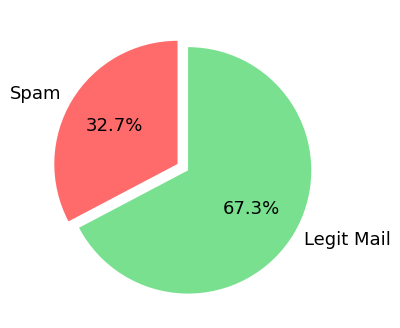

In [22]:
amounts_of_spam = data.CATEGORY.value_counts()[1]
amounts_of_ham = data.CATEGORY.value_counts()[0]

category_names = ['Spam', 'Legit Mail']
sizes = [amounts_of_spam, amounts_of_ham]
custom_colors = ['#ff6b6b', '#78e08f']

plt.figure(figsize=(4,4))
plt.pie(sizes, labels=category_names, textprops={'fontsize': 13}, startangle= 90,
         autopct='%1.1f%%', colors=custom_colors, explode=[0, 0.1])
plt.show()

## Pre-Processing 

- Converting to lower case
- Tokenising
- Removing stop words (the, I, of , at, which, on, etc.)
- Stripping out HTML Tags
- Word stemming
- Remove punctuation


Download the NLTK Resources

In [23]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/burakbedir/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [24]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/burakbedir/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [25]:
stop_words = set(stopwords.words('english')) #set checking for match

In [34]:
msg = 'All work and no play makes Jack a dull boy. To be or not to be'

words = word_tokenize(msg.lower())

filtered_words = []

for word in words:
    if word not in stop_words:
        filtered_words.append(word)
print(filtered_words)

['work', 'play', 'makes', 'jack', 'dull', 'boy', '.']


Stemming is reducing words to their root form. Ex: 'fishing' --> 'fish'

In [41]:
msg = 'All work and no play makes Jack a dull boy. To be or not to be ? \
    Nobody expects the Spanish Inquisition!'

words = word_tokenize(msg.lower())

stemmer = PorterStemmer() # For other languages you can use SnowballStemmer()

# .isaplha() = True when its not a punctuation.

filtered_words = []

for word in words:
    if word not in stop_words and word.isalpha():
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)
print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', 'nobodi', 'expect', 'spanish', 'inquisit']


Purpose of HTML is formatting. We need to remove them

In [47]:
data.at[2, 'MESSAGE']

'This is a multi-part message in MIME format.\n\n\n\n------=_NextPart_000_1CDC19_01C25366.4B57F3A0\n\nContent-Type: text/plain;\n\n\tcharset="Windows-1252"\n\nContent-Transfer-Encoding: quoted-printable\n\n\n\n We dare you...\n\n Try to find a better annuity!\n\n=20\n\n  - 5.40% Guaranteed for 6 Years=0A=\n\n- 6 Year Surrender Charge=0A=\n\n- 5% Agent\n\nCommission up to age 80=09\n\nCall today for more information!\n\n 800-888-7641 ext. 103\n\n- or -\n\n\n\nPlease fill out the form below for more information\t=20\n\nName:\t \t  =09\n\nE-mail:\t \t=20\n\nPhone:\t \t=20\n\nCity:\t \t State:\t \t=20\n\n \t    =09\n\n=20\n\n PMG Financial Services\n\n*5.40% for deposits of $100,000 and up, 5.25% interest for deposits\n\ntotalling $25,000-$99,999.\t=20\n\nWe don\'t want anyone to receive our mailings who does not wish to\n\nreceive them. This is a professional communication sent to insurance\n\nprofessionals. To be removed from this mailing list, DO NOT REPLY to\n\nthis message. Instead, g

In [51]:
soup = BeautifulSoup(data.at[2, 'MESSAGE'], 'html.parser')
print(soup.prettify())

This is a multi-part message in MIME format.



------=_NextPart_000_1CDC19_01C25366.4B57F3A0

Content-Type: text/plain;

	charset="Windows-1252"

Content-Transfer-Encoding: quoted-printable



 We dare you...

 Try to find a better annuity!

=20

  - 5.40% Guaranteed for 6 Years=0A=

- 6 Year Surrender Charge=0A=

- 5% Agent

Commission up to age 80=09

Call today for more information!

 800-888-7641 ext. 103

- or -



Please fill out the form below for more information	=20

Name:	 	  =09

E-mail:	 	=20

Phone:	 	=20

City:	 	 State:	 	=20

 	    =09

=20

 PMG Financial Services

*5.40% for deposits of $100,000 and up, 5.25% interest for deposits

totalling $25,000-$99,999.	=20

We don't want anyone to receive our mailings who does not wish to

receive them. This is a professional communication sent to insurance

professionals. To be removed from this mailing list, DO NOT REPLY to

this message. Instead, go here: http://www.insuranceiq.com/optout
<http: optout="" www.insuranceiq.com

In [53]:
print(soup.get_text())

This is a multi-part message in MIME format.



------=_NextPart_000_1CDC19_01C25366.4B57F3A0

Content-Type: text/plain;

	charset="Windows-1252"

Content-Transfer-Encoding: quoted-printable



 We dare you...

 Try to find a better annuity!

=20

  - 5.40% Guaranteed for 6 Years=0A=

- 6 Year Surrender Charge=0A=

- 5% Agent

Commission up to age 80=09

Call today for more information!

 800-888-7641 ext. 103

- or -



Please fill out the form below for more information	=20

Name:	 	  =09

E-mail:	 	=20

Phone:	 	=20

City:	 	 State:	 	=20

 	    =09

=20

 PMG Financial Services

*5.40% for deposits of $100,000 and up, 5.25% interest for deposits

totalling $25,000-$99,999.	=20

We don't want anyone to receive our mailings who does not wish to

receive them. This is a professional communication sent to insurance

professionals. To be removed from this mailing list, DO NOT REPLY to

this message. Instead, go here: http://www.insuranceiq.com/optout

=20



Legal Notice =20



------=_

### Defining General Function for Email Processing

In [54]:
def clean_message(message, stemmer= PorterStemmer(), stop_words=set(stopwords.words('english'))):
    """ Remove HTML part. Converts the message to lower case and splits up the words. Then removes the stop words and punctuation. """

    soup = BeautifulSoup(message, 'html.parser')
    cleaned_text = soup.get_text()
    words = word_tokenize(cleaned_text.lower())

    filtered_words = []

    for word in words:
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))

    return filtered_words

In [55]:
clean_message(data.at[2,'MESSAGE'])

['messag',
 'mime',
 'format',
 'dare',
 'tri',
 'find',
 'better',
 'annuiti',
 'guarante',
 'year',
 'surrend',
 'agent',
 'commiss',
 'age',
 'call',
 'today',
 'inform',
 'ext',
 'pleas',
 'fill',
 'form',
 'inform',
 'name',
 'phone',
 'citi',
 'state',
 'pmg',
 'financi',
 'servic',
 'deposit',
 'interest',
 'deposit',
 'total',
 'want',
 'anyon',
 'receiv',
 'mail',
 'wish',
 'receiv',
 'profession',
 'commun',
 'sent',
 'insur',
 'profession',
 'remov',
 'mail',
 'list',
 'repli',
 'messag',
 'instead',
 'go',
 'http',
 'legal',
 'notic',
 'dare',
 'find',
 'better',
 'annuiti',
 'call',
 'today',
 'inform',
 'pleas',
 'fill',
 'form',
 'inform',
 'name',
 'phone',
 'citi',
 'state',
 'deposit',
 'interest',
 'deposit',
 'total',
 'want',
 'anyon',
 'receiv',
 'mail',
 'wish',
 'receiv',
 'profession',
 'sent',
 'insur',
 'profession',
 'remov',
 'list',
 'repli',
 'messag',
 'instead',
 'go',
 'http',
 'legal',
 'notic']

In [56]:
nested_list = data.MESSAGE.apply(clean_message) #apply our function on all the messages in the dataframe

/var/folders/0v/n3w11jxs0zxdx0ty34xv_fx40000gn/T/ipykernel_1089/2944835805.py:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(message, 'html.parser')
/var/folders/0v/n3w11jxs0zxdx0ty34xv_fx40000gn/T/ipykernel_1089/2944835805.py:4: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  soup = BeautifulSoup(message, 'html.parser')


In [57]:
nested_list.tail()

DOC_ID
5791    [one, work, well, week, te, updat, server, syn...
5792    [damien, morton, quot, approv, html, abl, say,...
5793    [mon, che, wrote, that, correct, line, ad, rep...
5794    [upon, time, manfr, wrote, would, like, instal...
5795    [run, pick, use, new, ftoc, button, show, mess...
Name: MESSAGE, dtype: object

In [66]:
doc_ids_spam = data[data.CATEGORY == 1].index
doc_ids_ham =  data[data.CATEGORY == 0].index

In [68]:
nested_list_ham = nested_list.loc[doc_ids_ham]
nested_list_ham.shape


(3900,)

In [69]:
nested_list_spam = nested_list.loc[doc_ids_spam]
nested_list_spam.shape

(1896,)

In [70]:
flat_list_ham = [item for sublist in nested_list_ham for item in sublist]
normal_words = pd.Series(flat_list_ham).value_counts()

normal_words.shape[0]

20815

In [71]:
normal_words[:10]

http      7563
use       3633
list      2880
one       2373
get       2286
mail      2255
would     2003
like      1931
messag    1849
work      1800
Name: count, dtype: int64

In [72]:
flat_list_spam = [item for sublist in nested_list_spam for item in sublist]
spam_words = pd.Series(flat_list_spam).value_counts()

spam_words.shape[0]

13242

In [73]:
spam_words[:10]

http      3097
email     3090
free      2585
click     2058
receiv    1989
list      1971
get       1914
pleas     1852
busi      1792
order     1746
Name: count, dtype: int64

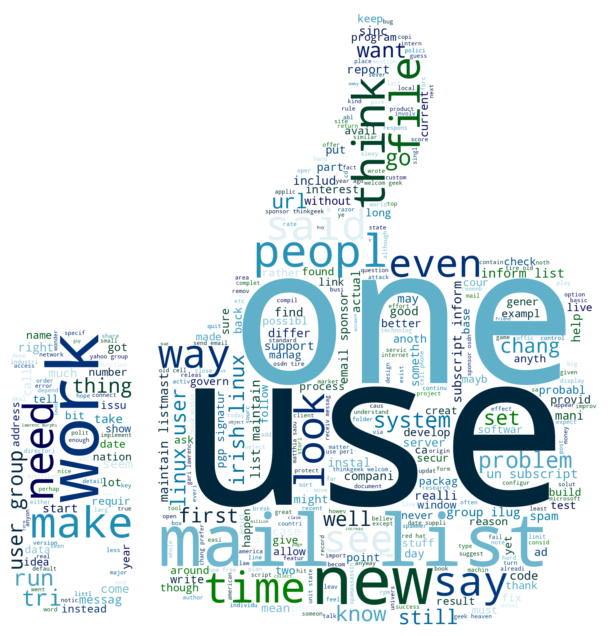

In [83]:
icon = Image.open(thums_up_file)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255,255,255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask) #converts the image object to an array

ham_str = ' '.join(flat_list_ham)

word_cloud = WordCloud(mask=rgb_array, background_color='white', max_words=400, colormap='winter')

word_cloud.generate(ham_str)


plt.figure(figsize=[16,8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

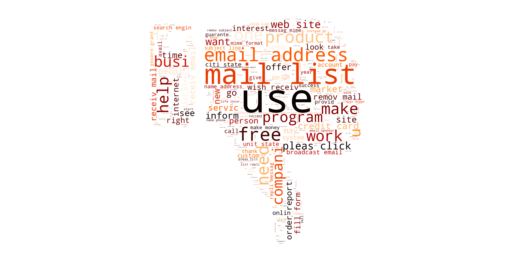

In [86]:
icon = Image.open(thums_down_file)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255,255,255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask) #converts the image object to an array

spam_str = ' '.join(flat_list_spam)

word_cloud = WordCloud(mask=rgb_array, background_color='white', max_words=400, colormap='gist_heat')

word_cloud.generate(spam_str)


plt.figure(figsize=[16,8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Generate Vocabulary & Dictionary

2500 most frequent words in our dataset are going to form our vocabulary.

In [87]:
stemmed_nested_list = data.MESSAGE.apply(clean_message)

flat_stemmed_list = [item for sublist in stemmed_nested_list for item in sublist]

/var/folders/0v/n3w11jxs0zxdx0ty34xv_fx40000gn/T/ipykernel_1089/2944835805.py:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(message, 'html.parser')
/var/folders/0v/n3w11jxs0zxdx0ty34xv_fx40000gn/T/ipykernel_1089/2944835805.py:4: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  soup = BeautifulSoup(message, 'html.parser')


In [88]:
unique_words = pd.Series(flat_stemmed_list).value_counts()
print('Nr of Unique Words:', unique_words.shape[0])
unique_words.head()

Nr of Unique Words: 27334


http     10660
use       5019
list      4851
email     4367
get       4200
Name: count, dtype: int64

In [91]:
frequent_words = unique_words[0:vocab_size] # Get the most common 2500 words 
frequent_words[:10]

http     10660
use       5019
list      4851
email     4367
get       4200
mail      3983
one       3907
free      3202
time      3042
work      2883
Name: count, dtype: int64

In [92]:
word_ids = list(range(0,vocab_size))

vocab = pd.DataFrame({'VOCAB_WORD': frequent_words.index.values}, index=word_ids)
vocab.index.name = 'WORD_ID'
vocab.head()

,VOCAB_WORD
WORD_ID,
0,http
1,use
2,list
3,email
4,get


Save the Vocab as a CSV File

In [94]:
vocab.to_csv(word_id_file, index_label=vocab.index.name, header=vocab.VOCAB_WORD.name)

# Split Train and Test

In [96]:
word_columns_df = pd.DataFrame.from_records(stemmed_nested_list.tolist())
word_columns_df.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
0,dear,homeown,interest,rate,lowest,point,year,help,find,best,...,None,None,None,None,None,None,None,None,None,None
1,attent,must,comput,user,packag,deal,norton,systemwork,softwar,suit,...,None,None,None,None,None,None,None,None,None,None
2,messag,mime,format,dare,tri,find,better,annuiti,guarante,year,...,None,None,None,None,None,None,None,None,None,None
3,import,inform,new,domain,name,final,avail,gener,public,discount,...,None,None,None,None,None,None,None,None,None,None
4,bottom,line,give,away,cd,free,peopl,like,one,month,...,None,None,None,None,None,None,None,None,None,None


In [98]:
word_columns_df.shape  #7671 is the nr. of words in the longest email

(5796, 7671)

In [103]:
X_train, X_test, y_train, y_test = train_test_split(word_columns_df, data.CATEGORY, test_size=0.3, random_state=42)

In [107]:
print('Nr of training samples:', X_train.shape[0])
print('Fraction of training set', X_train.shape[0] / word_columns_df.shape[0])

Nr of training samples: 4057
Fraction of training set 0.6999654934437544


In [108]:
X_train.index.name = X_test.index.name = 'DOC_ID'
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4844,thu,jul,rodent,unusu,size,wrote,appli,one,three,order,...,None,None,None,None,None,None,None,None,None,None
4727,well,would,vaniti,list,forward,least,littl,pure,data,week,...,None,None,None,None,None,None,None,None,None,None
5022,world,wide,word,issu,saturday,august,sent,saturday,subscrib,least,...,None,None,None,None,None,None,None,None,None,None
3504,believ,spamassassin,maintain,scheme,wherebi,corpu,distribut,ie,sever,peopl,...,None,None,None,None,None,None,None,None,None,None
3921,sorri,think,send,realiz,list,sender,usual,anyawi,ask,harri,...,None,None,None,None,None,None,None,None,None,None


In [109]:
y_train.head()

DOC_ID
4844    0
4727    0
5022    0
3504    0
3921    0
Name: CATEGORY, dtype: int64

## Sparse Matrix

In [111]:
word_index = pd.Index(vocab.VOCAB_WORD)

In [112]:
word_index.get_loc('thu')

393

In [113]:
def make_sparse_matrix(df, indexed_words, labels):
    """
    Returns sparse matrix as dataframe

    df: A dataframe with words in the columns with a document_id as an index (X_train or X_test)
    indexed_words: index of words ordered by word id
    labels: category as a series (y_train or y_test)
    """
    nr_rows = df.shape[0]
    nr_cols = df.shape[1]

    word_set = set(indexed_words)
    dict_list = []

    for i in range(nr_rows):
        for j in range(nr_cols):
            word = df.iat[i,j]
            if word in word_set:
                doc_id = df.index[i]
                word_id = indexed_words.get_loc(word)
                category = labels.at[doc_id]

                item = {'LABEL': category, 'DOC_ID': doc_id, 'OCCURENCE': 1, 'WORD_ID': word_id}

                dict_list.append(item)

    return pd.DataFrame(dict_list)

In [114]:
sparse_train_df = make_sparse_matrix(X_train, word_index, y_train)

In [115]:
sparse_train_df.head()

,LABEL,DOC_ID,OCCURENCE,WORD_ID
0,0,4844,1,393
1,0,4844,1,492
2,0,4844,1,2371
3,0,4844,1,497
4,0,4844,1,37


In [116]:
sparse_train_df.shape

(444950, 4)

In [121]:
train_grouped = sparse_train_df.groupby(['DOC_ID','WORD_ID','LABEL']).sum()
train_grouped.head()

OCCURENCE
DOC_ID WORD_ID LABEL           
0      0       1              2
       7       1              1
       16      1              1
       18      1              1
       24      1              1

In [118]:
vocab.at[0,'VOCAB_WORD']

'http'

In [122]:
train_grouped = train_grouped.reset_index()
train_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,0,0,1,2
1,0,7,1,1
2,0,16,1,1
3,0,18,1,1
4,0,24,1,1


In [124]:
np.savetxt(train_data_file, train_grouped, fmt= '%d')

In [126]:
sparse_test_df = make_sparse_matrix(X_test, word_index, y_test)

In [127]:
test_grouped = sparse_test_df.groupby(['DOC_ID','WORD_ID','LABEL']).sum().reset_index()
test_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,8,7,1,1
1,8,8,1,1
2,8,12,1,1
3,8,21,1,2
4,8,26,1,1


In [128]:
test_grouped.shape

(110579, 4)

In [129]:
np.savetxt(test_data_file, test_grouped, fmt= '%d')